#### What is this notebook?

This notebook is made for running parameter experiments. Since I have taken out the hard coded numerical variables, I gathered it in a `parameters.json` file and here.  When the model is basically done, you can run the experiments here rather easily.

#### How to use this notebook?

Hints:  
1. Run `%load para.py` and it will load the code and default parameters from `para.py` directly into the same cell. Then, you can modify the parameters to experiment.  
  
2. Only modify the `parameters.json` is enough for the current stage. After modifying the root `parameters.json` file, the modifed file will be saved in the simulation result folder. The result folder is structured as `%d-%m-%Y&%H-%M-%S`

3. After modifying all `parameters.json`, adjust `vec1` if necessary. Then hit `Run All`. The results and parameters used to create the results are saved in the `run_results` folder.  
  
4. Please COMMENT OUT the `from variables import *`to have the file saved properly!!! (trying to have a improve method)

5.  Read the `.svg` by dragging it to a brower.
  
When to change the code: 
1. No need to change this notebook unless `vec1` is changed. If you want to change `vec1`, then change the respective code in Cell 1.  
2. If `main.py` is updated, then please reload the Cell 3. Reloading method refer to point 1 and comment out the `from variables import *` according to point 4.

#### Cell 1: Load parameters

In [4]:
# %load variables.py
import scipy.special as sp
import pandas as pd
import numpy as np
import os
import json
with open("parameters.json", "r") as f:
    params = json.load(f)

year = params["year"] # simulation years
num_house = params["num_house"] # number of initial houses
land_cells = params["land_cells"] # initial amount of land cells
prod_multiplier = params["prod_multiplier"]
fishing_discount = params["fishing_discount"]
fallow_ratio = params["fallow_ratio"] # % of the total land
fallow_period = params["fallow_period"] # years
food_expiration_steps = params["food_expiration_steps"] # initial 3, by changing it from 3 to 2, everything changed a lot!
marriage_from = params["marriage_from"]
marriage_to = params["marriage_to"]
bride_price_ratio = params["bride_price_ratio"] # by changing it up, I haven't observed any changes yet
land_ecovery_rate = params["land_ecovery_rate"] # initial 0.03
land_max_capacity = params["land_max_capacity"] # initial 10
initial_quality = params["initial_quality"] # initial 5
fish_chance = params["fish_chance"] # initial 0.3
exchange_rate = params["exchange_rate"] # luxury to food # by changing it from 10 to 30, the gini changed a lot
luxury_good_storage = params["luxury_good_storage"] # initial 0
storage_ratio_low = params["storage_ratio_low"]
storage_ratio_high = params["storage_ratio_high"]
land_capacity_low = params["land_capacity_low"]
max_member = params["max_member"]
excess_food_ratio = params["excess_food_ratio"] # initial 2
trade_back_start = params["trade_back_start"]
lux_per_year = params["lux_per_year"] # initial 5 lowering it lower the gini coefficient
land_depreciate_factor = params["land_depreciate_factor"] # very important, when it was 0.01, the population died after 1000 years
fertility_scaler = params["fertility_scaler"] # very important, society cannot live up to 1000 yr if it is below 4 or 3. however, then the accumulative population is too much
file_path = params["file_path"]
file_name = params["file_name"]

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()
new_max_age = 60
old_max_age = vec1['age'].max()
scale_factor = new_max_age / old_max_age
scale_factor = 1
other_para = ['rho', 'pstar', 'mortparms']
bins = pd.cut(vec1['age'], bins=new_max_age)

binned_vec = pd.DataFrame()
for col in other_para:
    binned_col = vec1.groupby(bins, observed=False).agg({col: 'mean'}).reset_index()
    binned_col[col] = binned_col[col] * scale_factor
    binned_vec[col] = binned_col[col]

bin_centers = [interval.mid for interval in binned_col['age']]
binned_vec = binned_vec.rename_axis('age_new').reset_index()
binned_vec.loc[binned_vec['age_new'] <= 3, 'pstar'] *= 0.5

binned_vec['mstar'] = vec1['mstar']
binned_vec['fertparm'] = vec1['fertparm']
binned_vec['mortscale'] = vec1['mortscale']
binned_vec['fertscale'] = vec1['fertscale']
binned_vec['phi'] = vec1['phi']
vec1 = binned_vec

#### Cell 2: Manage file system

In [5]:
import os
import datetime
from IPython.display import clear_output
timestamp = datetime.datetime.now().strftime("%d-%m-%Y&%H-%M-%S")
folder_name = f"land_run_results/{timestamp}"
file_name = f"{folder_name}/{file_name}"
file_path = f"{folder_name}/{file_path}"
os.makedirs(folder_name, exist_ok=True)
with open(os.path.join(folder_name, "parameters.json"), "w") as f:
    json.dump(params, f, indent=4)

#### Cell 3: Run the main.py


Simulation Year 0
Last year:130
village has 0 new born.

Simulation Year 1
Last year:130
village has 1 new born.

Simulation Year 2
Last year:131
village has 3 new born.

Simulation Year 3
Last year:134
village has 3 new born.

Simulation Year 4
Last year:137
village has 6 new born.

Simulation Year 5
Last year:141
village has 5 new born.

Simulation Year 6
Last year:144
village has 4 new born.

Simulation Year 7
Last year:146
village has 6 new born.

Simulation Year 8
Last year:150
village has 8 new born.

Simulation Year 9
Last year:155
village has 10 new born.

Simulation Year 10
Last year:161
village has 2 new born.

Simulation Year 11
Last year:162
village has 12 new born.

Simulation Year 12
Last year:170
village has 10 new born.

Simulation Year 13
Last year:177
village has 12 new born.

Simulation Year 14
Last year:183
village has 6 new born.

Simulation Year 15
Last year:188
village has 12 new born.

Simulation Year 16
Last year:195
village has 7 new born.

Simulation Year 17

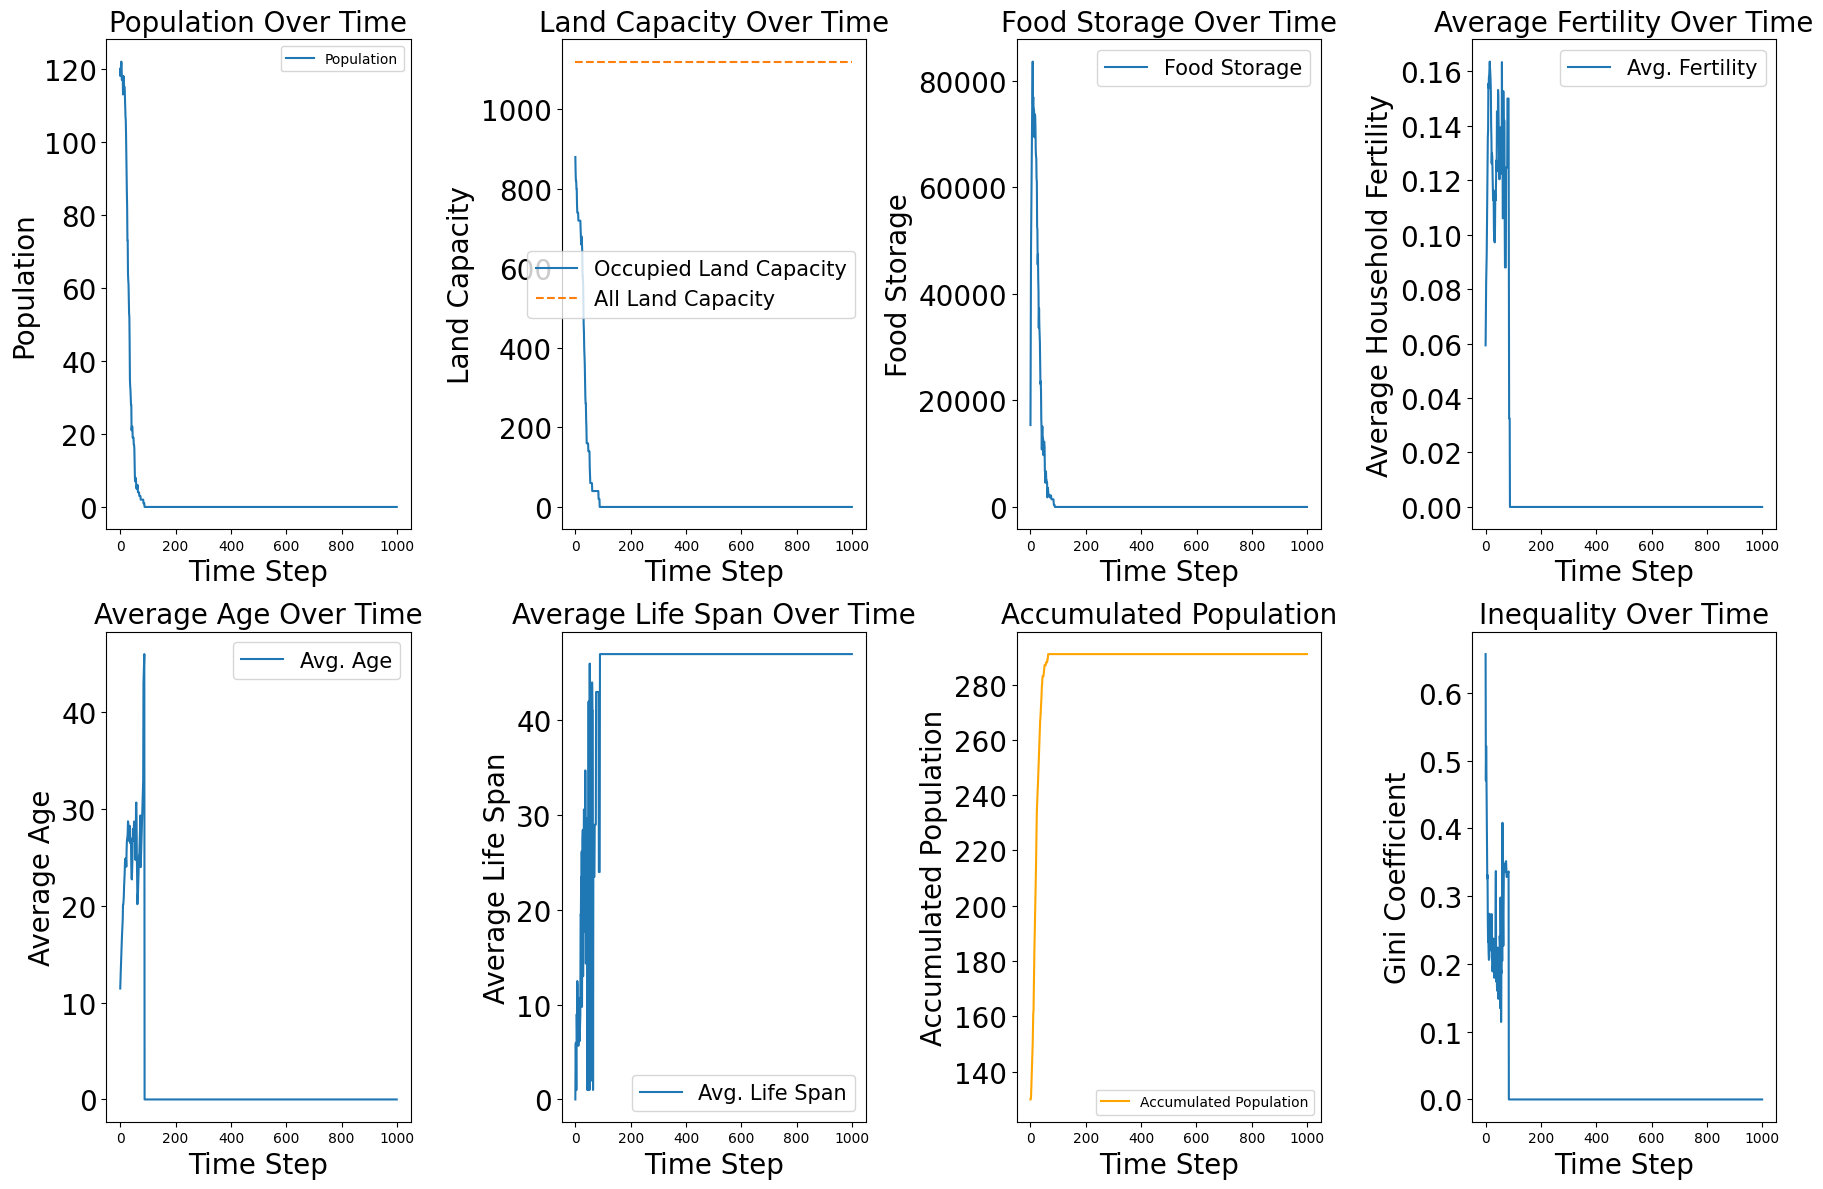

In [6]:
# %load main.py
from household import Household
from village import Village
from agent import Agent
from agent import Vec1
# from variables import *
import pandas as pd
import utils
import random
import math
import sys
from IPython.display import clear_output

random.seed(10)
# args = sys.argv
# if len(args) > 1:
#     random.seed(int(args[1]))
vec1_instance = Vec1()
village = utils.generate_random_village(num_house, land_cells, vec1_instance, food_expiration_steps, land_ecovery_rate, land_max_capacity, initial_quality, fish_chance, fallow_period)
village.initialize_network()
village.initialize_network_relationship()
for _ in range(year): 
    village.run_simulation_step(vec1_instance, prod_multiplier = prod_multiplier, fishing_discount = fishing_discount, fallow_ratio = fallow_ratio, fallow_period = fallow_period, food_expiration_steps = food_expiration_steps, marriage_from = marriage_from, marriage_to = marriage_to, bride_price_ratio = bride_price_ratio, exchange_rate = exchange_rate, storage_ratio_low=storage_ratio_low, storage_ratio_high=storage_ratio_high, land_capacity_low = land_capacity_low, max_member=max_member, excess_food_ratio = excess_food_ratio, trade_back_start = trade_back_start, lux_per_year = lux_per_year, land_depreciate_factor = land_depreciate_factor, fertility_scaler = fertility_scaler, spare_food_enabled=False, fallow_farming = False) # no fallow
    # utils.print_village_summary(village)
    
village.plot_simulation_results(file_name)
village.generate_animation(file_path, grid_dim=math.ceil(math.sqrt(land_cells)))
# clear_output()
